<a href="https://colab.research.google.com/github/ccg-esb/MI/blob/main/MI_3_PopulationModel_Parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook focuses on the parameterization of a population dynamics model for bacterial communities. It combines experimental data with mathematical modeling to estimate key parameters governing bacterial growth, competition, and response to environmental conditions, including antibiotic treatment. The notebook includes loading and preprocessing experimental datasets, defining the genetic space of possible bacterial genotypes, and implementing a Monod-like growth model using Gillespie simulations. Additionally, it explores optimization techniques to fit model parameters to observed data, facilitating a deeper understanding of bacterial population behaviors under different scenarios.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
from scipy.optimize import curve_fit, minimize, differential_evolution
from sklearn.metrics import r2_score
from pprint import pprint
from matplotlib.patches import Wedge
import time
import itertools
import os
import pickle
from google.colab import drive
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from google.auth import default
import seaborn as sns
import matplotlib.ticker as ticker


## Set experimental parameters

In [2]:

base_path = '/content/drive/MyDrive/SYNC_Projects/MI'

# Set initial resource, max time, and antibiotic concentration
initial_resource = 1.0
simulation_time = 24.0
B0=1e6

cassettes = ['1', '2', 'X']
num_cassettes=len(cassettes)

test_gene_labels=['GC1','GC2', 'X'] #Test parameters
#test_gene_labels=['aacA37','aacA45', 'X'] #High polarity
#test_gene_labels=['aacA37','smr1', 'X'] #Low Repressive

max_antibiotic_concentration = 1.0  # Example concentration

# Define base parameters for strains
base_birth_rate = 0.9
base_death_rate = 0.9
base_consumption_rate = 5e-9
base_half_saturation_resource = 0.5
base_half_saturation_antibiotic = 0.7

death_rate_scaling_constant = 0.5  # Adjust based on how strongly you want the protein concentration to affect death rate
birth_rate_scaling_constant = 0.02


## Load Data

In [3]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

#Data
sheet_url = 'https://docs.google.com/spreadsheets/d/1qJiSMeAn6yq9jhYNUi8X9zgw9gnzgbfuiCVTf6VTH2U/'

# Define the base path in Google Drive and a subdirectory for parameters
pathPARAMS = os.path.join(base_path, 'data/')
base_path = '/content/drive/My Drive/SYNC_Projects/MI/'  #
pathPARAMS = os.path.join(base_path, 'data/')
dirNameData = os.path.join(pathPARAMS, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
os.makedirs(dirNameData, exist_ok=True)

pathFIGURES = os.path.join(base_path, 'figures/')
dirNameFigures = os.path.join(pathFIGURES, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
os.makedirs(dirNameFigures, exist_ok=True)

if test_gene_labels[0] == 'GC1':  #Theoretical model
    k=0.45
    expe_label=f"X_GC1_GC2_k{int(k*100)}e-2"
    file_name_strains = f"X_{test_gene_labels[0]}_{test_gene_labels[1]}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2_strains.pkl"
    file_name = f"X_{test_gene_labels[0]}_{test_gene_labels[1]}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_k{int(k*100)}e-2.csv"
else: #From data
    expe_label=f"X_GC1_GC2"
    file_name_strains = f"X_{test_gene_labels[0]}_{test_gene_labels[1]}/X_{test_gene_labels[0]}_{test_gene_labels[1]}_strains.pkl"
    file_name = f"X_{test_gene_labels[0]}_{test_gene_labels[1]}/X_{test_gene_labels[0]}_{test_gene_labels[1]}.csv"

file_name_figures = f"{dirNameFigures}/{expe_label}"


Mounted at /content/drive


In [4]:

def loadData(sheet_url):
    """
    Load and process data from the specified Google Sheets URL, including sheets
    'Fluorescence', 'FitnessAerobiosis', and 'Recombination'.

    Parameters:
        sheet_url (str): The URL of the Google Sheets document to load.

    Returns:
        pd.DataFrame: A combined dataframe with data from all three sheets.
    """
    # Authenticate and authorize access to Google Sheets
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Open the Google Sheet by URL
    sheet = gc.open_by_url(sheet_url)

    # Load and process the 'Fluorescence' sheet
    worksheet_fluorescence = sheet.worksheet('Fluorescence')
    df_fluorescence = get_as_dataframe(worksheet_fluorescence, header=0)

    # Load and process the 'FitnessAerobiosis' sheet
    worksheet_fitness = sheet.worksheet('FitnessAerobiosis')
    df_fitness = get_as_dataframe(worksheet_fitness, header=0)
    df_fitness.rename(columns={df_fitness.columns[0]: 'GC'}, inplace=True)
    fitness_columns = df_fitness.columns[1:7]
    df_fitness['mean_fitness'] = df_fitness[fitness_columns].mean(axis=1)
    df_fitness['std_fitness'] = df_fitness[fitness_columns].std(axis=1)
    df_fitness_summary = df_fitness[['GC', 'mean_fitness', 'std_fitness']]

    # Merge the 'Fluorescence' and 'FitnessAerobiosis' dataframes
    df_combined = pd.merge(df_fluorescence, df_fitness_summary, on='GC', how='outer')

    # Load and process the 'Recombination' sheet
    worksheet_recombination = sheet.worksheet('Recombination')
    df_recombination = get_as_dataframe(worksheet_recombination, header=0)
    df_recombination.rename(columns={df_recombination.columns[0]: 'GC'}, inplace=True)
    recombination_columns = df_recombination.columns[1:7]
    df_recombination['mean_recombination'] = df_recombination[recombination_columns].mean(axis=1, skipna=True)
    df_recombination['std_recombination'] = df_recombination[recombination_columns].std(axis=1, skipna=True)
    df_recombination_summary = df_recombination[['GC', 'mean_recombination', 'std_recombination']]

    # Merge the 'Recombination' summary with the combined dataframe
    df_combined = pd.merge(df_combined, df_recombination_summary, on='GC', how='outer')

    return df_combined

# Usage example
#df_data = loadData(sheet_url)

# Display the first few rows to verify
#df_data.head()


In [5]:
# Define the list of specific values to filter
#filter_values = [test_gene_labels[0], test_gene_labels[1]]

# Filter df_combined based on the GC column
#df_filtered = df_data[df_data['GC'].isin(filter_values)]

# Display the filtered dataframe
#df_filtered


## Simple Monod Model (Gillespie)

In [6]:
def gillespie_bacterial_growth_batch(strains, initial_populations, initial_resource, simulation_time, antibiotic_concentration, dt=0.1):
    """
    Simulates bacterial growth with multiple mutant levels, resource limitation, and antibiotic-induced death
    using a batch update approach.

    Parameters:
    strains (list of dict): List of strain dictionaries with birth and death rates, mutation rate, etc.
        Each dictionary should include:
            - 'birth_rate' (float): Birth rate of the strain.
            - 'death_rate' (float): Base death rate of the strain.
            - 'half_saturation_resource' (float): Half-saturation constant for resource consumption.
            - 'half_saturation_antibiotic' (float): Half-saturation constant for antibiotic concentration.
            - 'consumption_rate' (float): Resource consumption rate per birth event.
    initial_populations (list or numpy array): Initial population sizes for each strain.
    initial_resource (float): Initial resource level.
    simulation_time (float): Maximum simulation time.
    antibiotic_concentration (float): Antibiotic concentration affecting death rate.
    dt (float): Time step for batch updates.

    Returns:
    t_values (list): Time points where changes occurred.
    population_values (list of list): Population sizes of each strain at corresponding time points.
    R_values (list): Resource levels at corresponding time points.
    """
    # Initialize time and populations
    t = 0
    populations = list(initial_populations)  # Use initial_populations directly
    R = initial_resource

    # Record initial conditions
    t_values = [t]
    population_values = [populations[:]]
    R_values = [R]

    while t < simulation_time:
        # Check for extinction or resource depletion
        if sum(populations) <= 0 or R <= 0:
            t += dt
            t_values.append(t)
            population_values.append(populations[:])
            R_values.append(R)
            continue

        # Calculate birth and death events for each strain
        births = [
            np.random.poisson(strain['birth_rate'] * populations[i] * (R / (R + strain['half_saturation_resource'])) * dt)
            for i, strain in enumerate(strains)
        ]

        deaths = [
            np.random.poisson(strain['death_rate'] * populations[i] * (antibiotic_concentration /
                    (antibiotic_concentration + strain['half_saturation_antibiotic'])) * dt)
            for i, strain in enumerate(strains)
        ]

        # Update populations and resources after birth and death events
        for i in range(len(populations)):
            populations[i] += births[i] - deaths[i]

        # Decrease resource based on total births across strains
        total_resource_consumption = sum(births[i] * strains[i]['consumption_rate'] for i in range(len(strains)))
        R -= total_resource_consumption

        # Ensure populations and resources are non-negative
        populations = [max(0, pop) for pop in populations]
        R = max(R, 0)

        # Advance time and record results
        t += dt
        t_values.append(t)
        population_values.append(populations[:])
        R_values.append(R)

    return t_values, population_values, R_values


## Model parametrization

In [7]:
from itertools import product

def generate_genotypes(cassettes, max_length=3):
    """Generate all possible genotypes up to max_length with duplicates, including the empty state."""
    empty_state = '0' * max_length  # Define the empty state based on max_length
    all_genotypes = {empty_state}  # Start with the empty genotype

    # Generate products of length 1 to max_length, allowing duplicates
    for r in range(1, max_length + 1):
        for genotype_tuple in product(cassettes, repeat=r):
            # Join the tuple to form a genotype string
            genotype = ''.join(genotype_tuple)
            # Pad with '0's on the right to reach max_length
            padded_genotype = genotype.ljust(max_length, '0')
            all_genotypes.add(padded_genotype)

    return sorted(all_genotypes)


## Parameteresing excision/insertion

In [8]:


# Define the full path to the file
file_path = os.path.join(pathPARAMS, file_name)

# Load the CSV file without headers
df_results_loaded = pd.read_csv(file_path, header=None, skiprows=1)
print(df_results_loaded)

# Manually assign column names (assuming the first column is genotype and the second is protein concentration)
df_results_loaded.columns = ['Genotype', 'Protein_Concentration']

# Create a dictionary to map each genotype to its protein concentration
genotype_to_concentration = dict(zip(df_results_loaded['Genotype'], df_results_loaded['Protein_Concentration']))

# Display the mapping
for genotype, concentration in genotype_to_concentration.items():
    print(f"Genotype {genotype}: Total protein concentration of X = {concentration}")

      0       1
0   111  0.0000
1   112  0.0000
2   11X  1.9683
3   110  0.0000
4   121  0.0000
5   122  0.0000
6   12X  1.7496
7   120  0.0000
8   1X1  2.4300
9   1X2  2.4300
10  1XX  4.1796
11  1X0  2.4300
12  100  0.0000
13  211  0.0000
14  212  0.0000
15  21X  1.7496
16  210  0.0000
17  221  0.0000
18  222  0.0000
19  22X  1.5552
20  220  0.0000
21  2X1  2.1600
22  2X2  2.1600
23  2XX  3.7152
24  2X0  2.1600
25  200  0.0000
26  X11  3.0000
27  X12  3.0000
28  X1X  4.7496
29  X10  3.0000
30  X21  3.0000
31  X22  3.0000
32  X2X  4.5552
33  X20  3.0000
34  XX1  5.1600
35  XX2  5.1600
36  XXX  6.7152
37  XX0  5.1600
38  X00  3.0000
39  000  0.0000
Genotype 111: Total protein concentration of X = 0.0
Genotype 112: Total protein concentration of X = 0.0
Genotype 11X: Total protein concentration of X = 1.968300000061333
Genotype 110: Total protein concentration of X = 0.0
Genotype 121: Total protein concentration of X = 0.0
Genotype 122: Total protein concentration of X = 0.0
Genotype 12X

In [9]:
def generate_genotypes(num_cassettes):
    """Generate all possible genotypes with up to num_cassettes, including empty state and 'X' substitution."""
    cassettes = list(range(1, num_cassettes)) + ['X']  # Include X and range up to num_cassettes - 1
    all_genotypes = [tuple('0' for _ in range(num_cassettes))]  # Start with the all-zero genotype

    for k in range(1, num_cassettes + 1):  # Generate genotypes of all lengths from 1 to num_cassettes
        for genotype in itertools.product(cassettes, repeat=k):
            padded_genotype = tuple(list(genotype) + ['0'] * (num_cassettes - len(genotype)))
            all_genotypes.append(padded_genotype)

    return all_genotypes

list_genotypes=generate_genotypes(num_cassettes)
labels_genotypes=["".join(map(str, genotype)) for genotype in list_genotypes]

print(labels_genotypes)

['000', '100', '200', 'X00', '110', '120', '1X0', '210', '220', '2X0', 'X10', 'X20', 'XX0', '111', '112', '11X', '121', '122', '12X', '1X1', '1X2', '1XX', '211', '212', '21X', '221', '222', '22X', '2X1', '2X2', '2XX', 'X11', 'X12', 'X1X', 'X21', 'X22', 'X2X', 'XX1', 'XX2', 'XXX']


In [10]:


# Initialize strain parameters list
strains = []

# Define color maps for each 'X' position
blue_cmap = plt.colormaps['Blues'](np.linspace(0.2, 1, 10))
green_cmap = plt.colormaps['Greens'](np.linspace(0.2, 1, 10))
red_cmap = plt.colormaps['Reds'](np.linspace(0.2, 1, 10))
grey_cmap = plt.colormaps['Greys'](np.linspace(0.2, 0.8, 10))  # Gradient for genotypes without 'X'

# Generate parameters for each genotype
for i, strainArray in enumerate(list_genotypes):
    # Fetch protein concentration, defaulting to zero if not found
    strainID = labels_genotypes[i]
    protein_concentration = genotype_to_concentration.get(strainID, 0)

    # Adjusted death rate formula using the scaling constant
    death_rate = base_death_rate / (1 + death_rate_scaling_constant * protein_concentration)

    # Calculate birth rate reduction based on protein concentration
    birth_rate_reduction = birth_rate_scaling_constant * protein_concentration
    birth_rate = max(0, base_birth_rate - birth_rate_reduction)

    # Assign colors based on the position of 'X'
    if strainID[0] == 'X':  # First position
        color = red_cmap[i % len(blue_cmap)]
    elif strainID[1] == 'X':  # Second position
        color = green_cmap[i % len(green_cmap)]
    elif strainID[2] == 'X':  # Third position
        color = blue_cmap[i % len(red_cmap)]
    else:  # No 'X' present
        color = grey_cmap[i % len(grey_cmap)]

    # Collect all parameters
    params = {
        'birth_rate': birth_rate,
        'consumption_rate': base_consumption_rate,
        'half_saturation_resource': base_half_saturation_resource,
        'death_rate': death_rate,
        'half_saturation_antibiotic': base_half_saturation_antibiotic,
        'color': color
    }

    # Construct strain dictionary
    strain = {
        'strainID': strainID,
        **params
    }
    strains.append(strain)

# Print generated strains to verify the results
for strain in strains:
    print(strain)


{'strainID': '000', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.88705882, 0.88705882, 0.88705882, 1.        ])}
{'strainID': '100', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.83633987, 0.83633987, 0.83633987, 1.        ])}
{'strainID': '200', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.77777778, 0.77777778, 0.77777778, 1.        ])}
{'strainID': 'X00', 'birth_rate': 0.8399999999996501, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.3599999999987402, 'half_saturation_antibiotic': 0.7, 'color': array([0.98535948, 0.45751634, 0.33202614, 1.        ])}
{'strainID': '110', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 

[{'strainID': '000', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.88705882, 0.88705882, 0.88705882, 1.        ])}, {'strainID': '100', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.83633987, 0.83633987, 0.83633987, 1.        ])}, {'strainID': '200', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.9, 'half_saturation_antibiotic': 0.7, 'color': array([0.77777778, 0.77777778, 0.77777778, 1.        ])}, {'strainID': 'X00', 'birth_rate': 0.8399999999996501, 'consumption_rate': 5e-09, 'half_saturation_resource': 0.5, 'death_rate': 0.3599999999987402, 'half_saturation_antibiotic': 0.7, 'color': array([0.98535948, 0.45751634, 0.33202614, 1.        ])}, {'strainID': '110', 'birth_rate': 0.9, 'consumption_rate': 5e-09, 'half_saturation_resour

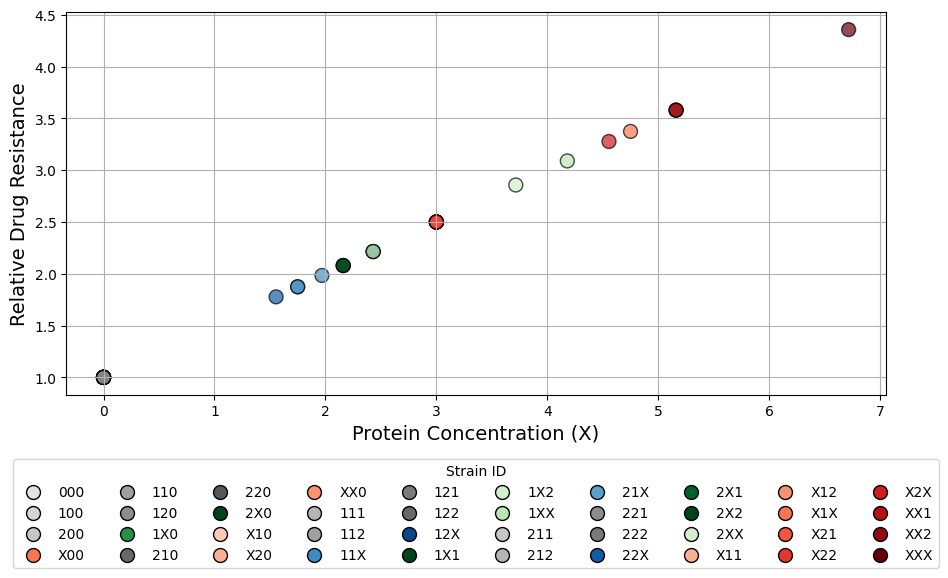

In [11]:
def plotRelativeResistance(strains, genotype_to_concentration, ncol=5, outPath=''):
    """
    Plots relative resistance vs. protein concentration for each strain with a custom legend below the plot.

    Parameters:
    strains (list of dict): List of strain parameters, including 'strainID', 'death_rate', and 'color'.
    genotype_to_concentration (dict): Dictionary mapping strain IDs to protein concentrations.
    ncol (int): Number of columns for the legend layout.
    """
    # Identify the death rate for the reference genotype "000"
    print(strains)
    reference_death_rate = next(strain['death_rate'] for strain in strains if strain['strainID'] == '000')

    # Calculate Relative Resistance as the inverse of relative susceptibility
    strainIDs = [strain['strainID'] for strain in strains]
    relative_resistance = [reference_death_rate / strain['death_rate'] if strain['death_rate'] > 0 else 0 for strain in strains]
    colors = [strain['color'] for strain in strains]
    protein_concentrations = [genotype_to_concentration.get(strainID, 0) for strainID in strainIDs]

    # Plot protein concentration vs. relative resistance
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(protein_concentrations, relative_resistance, c=colors, edgecolor='black', s=100, alpha=0.7)

    # Set labels and title
    ax.set_xlabel('Protein Concentration (X)', fontsize=14)
    ax.set_ylabel('Relative Drug Resistance', fontsize=14)
    ax.grid(True)

    # Create legend handles manually
    legend_handles = [
        plt.Line2D(
            [0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=strainID, markeredgecolor='black'
        )
        for strainID, color in zip(strainIDs, colors)
    ]

    # Place legend below the plot with multiple rows
    ax.legend(
        handles=legend_handles, title="Strain ID", fontsize=10, ncol=ncol, loc='upper center', bbox_to_anchor=(0.5, -0.15)
    )

    plt.tight_layout()

    # Save or show plot
    if outPath:
        filename = f"{outPath}_ParamsResistance.pdf"
        plt.savefig(filename, format='pdf')
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()

# Example usage
plotRelativeResistance(strains, genotype_to_concentration, ncol=10, outPath=file_name_figures)


Exporting /content/drive/My Drive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_k45e-2_ParamsCost.pdf


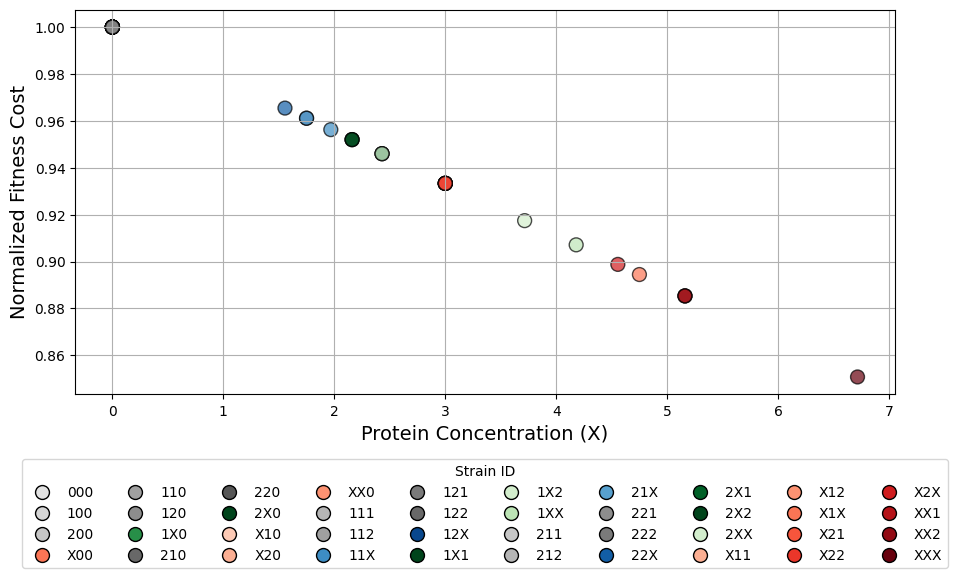

In [12]:

def plotFitnessCost(strains, genotype_to_concentration, ncol=5, outPath=''):
    """
    Plots normalized birth rate (fitness cost) vs. protein concentration for each strain,
    with a custom legend below the plot.

    Parameters:
    strains (list of dict): List of strain parameters, including 'strainID', 'birth_rate', and 'color'.
    genotype_to_concentration (dict): Dictionary mapping strain IDs to protein concentrations.
    ncol (int): Number of columns for the legend layout.
    """
    # Find the birth rate of the reference genotype '000'
    reference_birth_rate = next(strain['birth_rate'] for strain in strains if strain['strainID'] == '000')

    # Extract data for plotting
    strainIDs = [strain['strainID'] for strain in strains]
    birth_rates = [strain['birth_rate'] for strain in strains]
    colors = [strain['color'] for strain in strains]
    protein_concentrations = [genotype_to_concentration.get(strainID, 0) for strainID in strainIDs]

    # Calculate fitness cost as normalized birth rate with respect to '000'
    fitness_costs = [birth_rate / reference_birth_rate for birth_rate in birth_rates]

    # Plot protein concentration vs. fitness cost
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(protein_concentrations, fitness_costs, c=colors, edgecolor='black', s=100, alpha=0.7)

    # Set labels and title
    ax.set_xlabel('Protein Concentration (X)', fontsize=14)
    ax.set_ylabel('Normalized Fitness Cost', fontsize=14)
    ax.grid(True)

    # Create legend handles manually
    legend_handles = [
        plt.Line2D(
            [0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=strainID, markeredgecolor='black'
        )
        for strainID, color in zip(strainIDs, colors)
    ]

    # Place legend below the plot with multiple rows
    ax.legend(
        handles=legend_handles, title="Strain ID", fontsize=10, ncol=ncol, loc='upper center', bbox_to_anchor=(0.5, -0.15)
    )

    plt.tight_layout()

    # Save or show plot
    if outPath:
        filename = f"{outPath}_ParamsCost.pdf"
        plt.savefig(filename, format='pdf')
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()

plotFitnessCost(strains, genotype_to_concentration, ncol=10, outPath=file_name_figures)


Exporting /content/drive/My Drive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_k45e-2_ParamsTradeOff.pdf


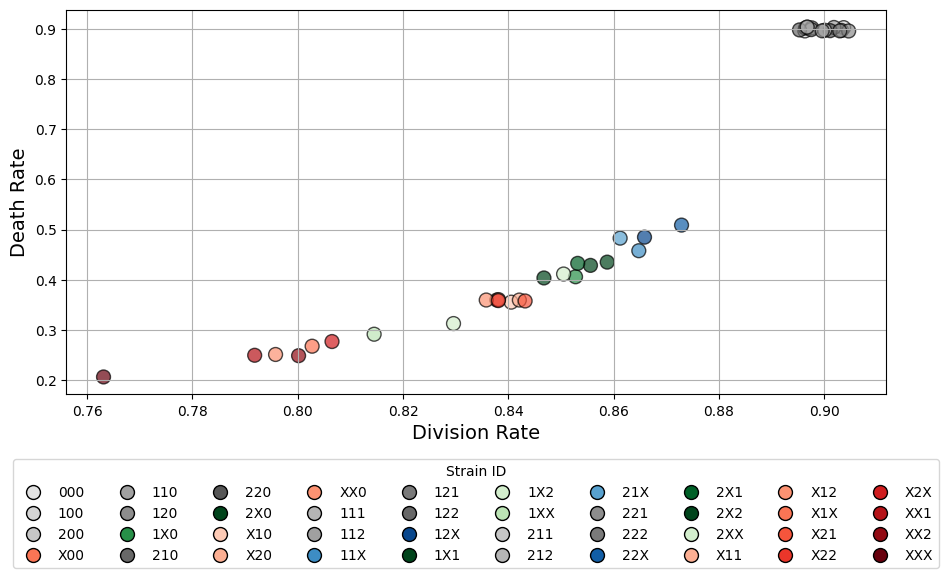

In [13]:


def plotBirthVsDeathRateScatter(strains, ncol=4, jitter_strength=0.01, alpha=0.7,outPath=''):
    """
    Plots a scatter plot of division (birth) rates vs. death rates for each strain with transparency and jitter.
    Each point is colored according to the strain's assigned color, with a legend displayed below the plot.

    Parameters:
    strains (list of dict): List of strain parameters with 'strainID', 'birth_rate', 'death_rate', and 'color'.
    ncol (int): Number of columns for the legend.
    jitter_strength (float): Maximum jitter strength for each point.
    alpha (float): Transparency level for scatter points.
    """
    # Extract birth rates, death rates, colors, and strain IDs
    birth_rates = [strain['birth_rate'] for strain in strains]
    death_rates = [strain['death_rate'] for strain in strains]
    colors = [strain['color'] for strain in strains]
    strainIDs = [strain['strainID'] for strain in strains]

    # Apply jitter
    jittered_birth_rates = np.array(birth_rates) + np.random.uniform(-jitter_strength, jitter_strength, len(birth_rates))
    jittered_death_rates = np.array(death_rates) + np.random.uniform(-jitter_strength, jitter_strength, len(death_rates))

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(jittered_birth_rates, jittered_death_rates, c=colors, edgecolor='black', s=100, alpha=alpha)

    # Create legend handles manually
    legend_handles = [
        plt.Line2D(
            [0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=strainID, markeredgecolor='black'
        )
        for strainID, color in zip(strainIDs, colors)
    ]

    # Place legend below the plot with multiple rows
    ax.legend(
        handles=legend_handles, title="Strain ID", fontsize=10, ncol=ncol, loc='upper center', bbox_to_anchor=(0.5, -0.15)
    )

    # Set labels and title
    ax.set_xlabel('Division Rate', fontsize=14)
    ax.set_ylabel('Death Rate', fontsize=14)
    ax.grid(True)
    plt.tight_layout()


    if outPath:
        filename = f"{outPath}_ParamsTradeOff.pdf"
        plt.savefig(filename, format='pdf')
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()

plotBirthVsDeathRateScatter(strains, ncol=10, jitter_strength=0.005, alpha=0.7, outPath=file_name_figures)


In [14]:
# Initialize lists to hold the results for each strain
all_time_points = []
all_population_values = []

# Set initial conditions
#B0 = 1e6  # Example initial population size for each strain
antibiotic_concentration = 0

# Run the simulation for each strain in the strains list
for strain in strains:
    # Run the simulation for the current strain only
    t_values, population_values, R_values = gillespie_bacterial_growth_batch(
        [strain],  # Pass only the current strain
        [B0],      # Initial population for this strain
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        antibiotic_concentration=antibiotic_concentration,
        dt=0.1
    )

    # Store the results for later plotting
    all_time_points.append(t_values)
    all_population_values.append(population_values)



Exporting /content/drive/My Drive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_k45e-2_GrowthCurves.pdf


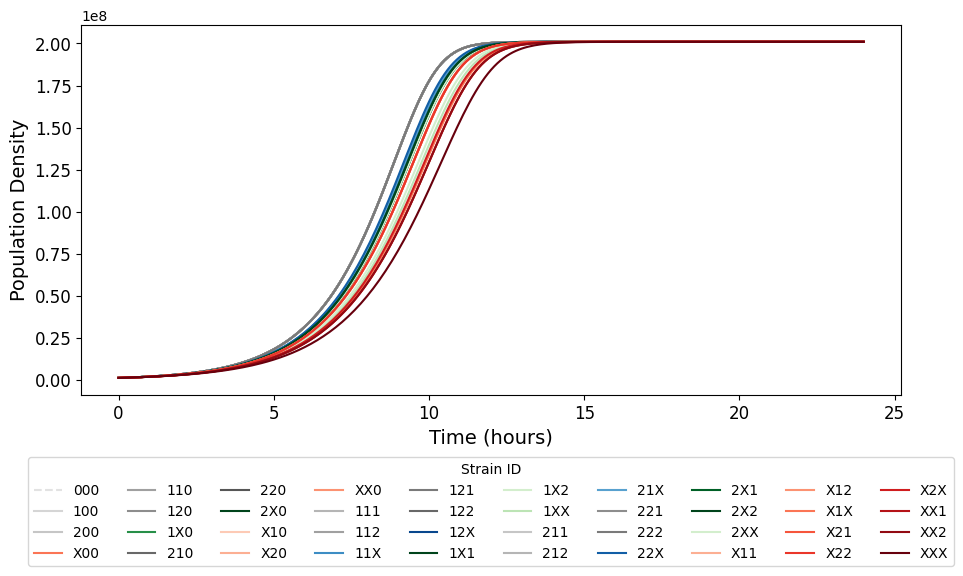

In [15]:

def plotDensities(all_time_points, all_population_values, strains, ncol=3, outPath=''):
    """
    Plots the population densities of each strain over time, using assigned colors for each strain.

    Parameters:
    all_time_points (list of list): Time points from the simulation for each strain.
    all_population_values (list of list of list): Population sizes of each strain at corresponding time points.
    strains (list of dict): List of strains with 'strainID' and 'color'.
    ncol (int): Number of columns in the legend.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot populations for each strain, using assigned colors
    for i, (time_points, population_values) in enumerate(zip(all_time_points, all_population_values)):
        color = strains[i]['color']  # Use the color assigned in each strain dictionary
        strain_label = strains[i]['strainID']
        linestyle = '--' if i == 0 else '-'  # Wild-type solid, mutants dashed
        ax.plot(time_points, [pop[0] for pop in population_values], label=strain_label, color=color, linestyle=linestyle)

    # Set labels and legend
    ax.set_xlabel('Time (hours)', fontsize=14)
    ax.set_ylabel('Population Density', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    # Place legend below the plot with multiple rows
    ax.legend(title="Strain ID", fontsize=10, ncol=ncol, loc='upper center', bbox_to_anchor=(0.5, -0.15))

    plt.tight_layout()

    if outPath:
        filename = f"{outPath}_GrowthCurves.pdf"
        plt.savefig(filename, format='pdf')
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()

plotDensities(all_time_points, all_population_values, strains, ncol=10, outPath=file_name_figures)


## Dose-response

In [16]:


def run_dose_response(strains, initial_population, initial_resource, simulation_time, antibiotic_concentrations, outPath=''):
    """
    Runs the gillespie_bacterial_growth_batch simulation over a range of antibiotic concentrations
    and returns the final population density (OD) for each concentration. Optionally plots OD vs. time
    for each concentration with each strain in its assigned color.

    Parameters:
    strains (list of dict): Strain parameters for the model.
    initial_population (float): Initial population density for each strain.
    initial_resource (float): Initial resource concentration.
    simulation_time (float): Duration of the simulation.
    antibiotic_concentrations (list or np.array): Array of antibiotic concentrations to simulate.
    toPlot (bool): Whether to plot OD vs. time for each concentration.

    Returns:
    dict: A dictionary with antibiotic concentrations as keys and final OD values as values.
    """
    final_ODs = {}  # Dictionary to store final OD for each antibiotic concentration

    # Set up for plotting if needed
    if outPath:
        plt.figure(figsize=(8, 6))  # Create a figure for plotting

    for i, antibiotic_concentration in enumerate(antibiotic_concentrations):
        # Run the simulation for the current antibiotic concentration
        t_values, population_values, R_values = gillespie_bacterial_growth_batch(
            strains, [initial_population] * len(strains), initial_resource, simulation_time, antibiotic_concentration
        )

        # Calculate and store the final OD for each antibiotic concentration
        final_population = np.sum([pop[-1] for pop in population_values])
        final_ODs[antibiotic_concentration] = final_population

        # Plot if toPlot is True
        if outPath:
            for j, strain in enumerate(strains):
                color = strain['color']
                strain_OD_values = [pop[j] for pop in population_values]
                plt.plot(t_values, strain_OD_values, color=color, linestyle='-', label=f"{strain['strainID']} (Conc: {antibiotic_concentration})")

    # Final plot adjustments

    if outPath:
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend(title="Strain ID and Antibiotic Conc", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()


        filename = f"{outPath}_GrowthCurves.pdf"
        plt.savefig(filename, format='pdf')
        print(f"Exporting {filename}")
        plt.show()
        plt.close()


    return final_ODs


def runDoseResponseForAllStrains(strains_list, initial_resource, simulation_time, antibiotic_concentration_range, B0, IC=90, outPath=''):
    """
    Runs the dose-response simulation for each strain and plots all curves together with IC annotations.

    Parameters:
    strains_list (list of dict): List of strain dictionaries, each with specific parameters.
    initial_resource (float): Initial resource concentration.
    simulation_time (float): Duration of the simulation.
    antibiotic_concentration_range (list or np.array): Array of antibiotic concentrations to simulate.
    B0 (float): Initial density for IC computation.
    IC (int): Percentage of inhibition for IC calculation (e.g., 90 for IC90).

    Returns:
    dict: Dictionary with strain IDs as keys and dose-response results as values.
    """
    all_dose_responses = {}  # Dictionary to store dose-response results for each strain
    IC_results = {}           # Dictionary to store IC values for each strain

    # Run dose-response simulation for each strain
    for strain in strains_list:
        strainID = strain['strainID']  # Get the strain ID

        # Run dose-response for the current strain
        final_ODs = run_dose_response(
            strains=[strain],  # Single strain in a list
            initial_population=B0,  # Pass the initial population density
            initial_resource=initial_resource,
            simulation_time=simulation_time,
            antibiotic_concentrations=antibiotic_concentration_range,
            outPath=''
        )

        # Compute IC for the current strain
        IC_concentration = computeIC(final_ODs, IC=IC, B0=B0)
        IC_results[strainID] = IC_concentration

        # Store the dose-response result
        all_dose_responses[strainID] = final_ODs

    # Plot all dose-response curves together
    plot_dose_response_all(all_dose_responses, IC_results, IC_label=f"IC{IC}", outPath=outPath)

    return all_dose_responses, IC_results


def plot_dose_response_all(dose_responses, IC_results, IC_label="IC90", ncol=10, outPath=''):
    """
    Plots the dose-response curves for multiple strains together, with IC annotations.

    Parameters:
    dose_responses (dict): Dictionary with strain IDs as keys and dose-response data as values.
    IC_results (dict): Dictionary with strain IDs as keys and computed IC values as values.
    IC_label (str): Label for the IC annotation (e.g., "IC90").
    ncol (int): Number of columns for the legend.
    """
    plt.figure(figsize=(8, 6))

    # Plot each strain's dose-response curve with assigned colors
    for strain in strains:
        strainID = strain['strainID']
        color = strain['color']

        # Get dose-response data for this strain
        if strainID in dose_responses:
            dose_response = dose_responses[strainID]
            concentrations = sorted(dose_response.keys())
            final_ODs = [dose_response[conc] for conc in concentrations]

            # Plot the dose-response curve
            plt.plot(concentrations, final_ODs, marker='o', linestyle='-', color=color, label=f'{strainID}')

            # Annotate IC value if it was calculated
            if IC_results.get(strainID, -1) != -1:
                IC_value = IC_results[strainID]
                plt.axvline(x=IC_value, color=color, linestyle='--', alpha=0.6)
                #plt.text(IC_value, max(final_ODs) * 0.8, f'{IC_label}', color=color, fontsize=10, ha='center')

    # Label axes and configure plot
    plt.xlabel('Antibiotic Concentration', fontsize=14)
    plt.ylabel('Final OD', fontsize=14)
    #plt.yscale('log')  # Use log scale for OD if necessary

    # Place legend below the plot in multiple columns
    plt.legend(title="Strain ID", fontsize=10, ncol=ncol, loc='upper center', bbox_to_anchor=(0.5, -0.2))

    plt.tight_layout()

    if outPath:
        filename = f"{outPath}_DoseResponseAll.pdf"
        plt.savefig(filename, format='pdf')
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()


def computeIC(dose_response_results, IC, B0):
    """
    Computes the inhibitory concentration (IC) at which the desired percentage of inhibition is achieved,
    adjusting for the provided initial density B0.

    Parameters:
    dose_response_results (dict): Dictionary with antibiotic concentrations as keys and final OD values as values.
    IC (float): Percentage of inhibition to estimate (e.g., 50 for IC50, 90 for IC90).
    B0 (float): Initial OD (or density) at the start of the experiment.

    Returns:
    float: Interpolated antibiotic concentration for the specified inhibition percentage.
           Returns -1 if the desired inhibition is not achieved within the concentration range.
    """
    # Sort the dose-response results by concentration
    concentrations = np.array(sorted(dose_response_results.keys()))
    final_ODs = np.array([dose_response_results[conc] for conc in concentrations])

    # Subtract the initial density B0 from final ODs to calculate net growth
    net_growth_ODs = final_ODs - B0

    # Ensure that net growth values do not go below zero
    net_growth_ODs = np.maximum(net_growth_ODs, 0)

    # Calculate the target OD for the given inhibition percentage
    max_net_OD = net_growth_ODs[0]  # Assuming the first concentration has no drug
    target_OD = (1 - IC / 100) * max_net_OD

    # Check if the target OD is achieved within the given concentration range
    if np.all(net_growth_ODs > target_OD):
        #print("Target OD not achieved within the tested concentrations.")
        return -1  # Target inhibition not achieved

    # Find the concentrations surrounding the target OD for interpolation
    below_target = net_growth_ODs > target_OD
    idx_above = np.argmax(~below_target)  # First index where OD <= target_OD
    idx_below = idx_above - 1

    # Ensure there is a valid range for interpolation
    if idx_below < 0 or idx_above >= len(concentrations):
        #print("Interpolation failed: no valid points surrounding the target OD.")
        return -1

    # Linear interpolation to estimate IC value
    conc_below, conc_above = concentrations[idx_below], concentrations[idx_above]
    OD_below, OD_above = net_growth_ODs[idx_below], net_growth_ODs[idx_above]

    IC_concentration = conc_below + (target_OD - OD_below) * (conc_above - conc_below) / (OD_above - OD_below)
    return IC_concentration


Exporting /content/drive/My Drive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_k45e-2_DoseResponseAll.pdf


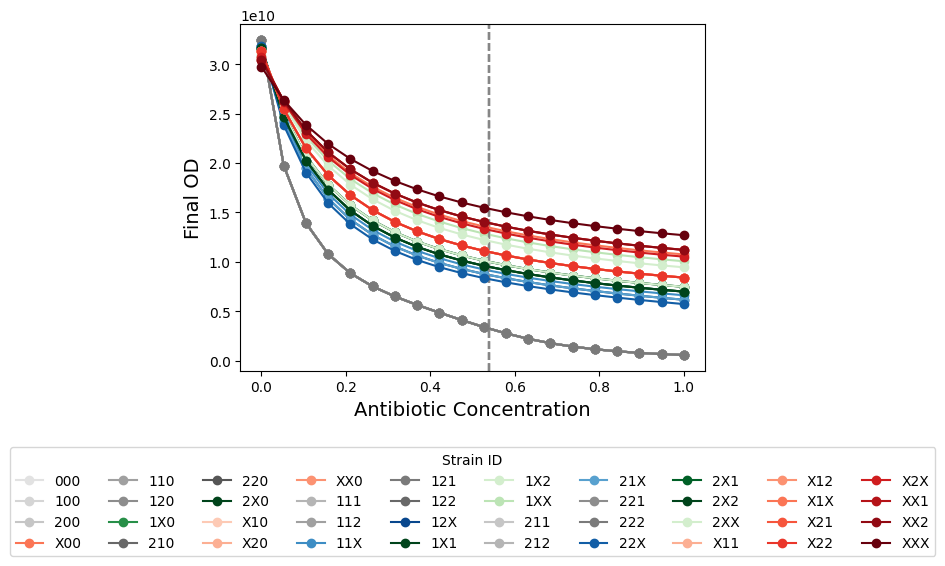

Dose-response for each strain: {'000': {0.0: 32447972336.0, 0.05263157894736842: 19738429737.0, 0.10526315789473684: 13921664885.0, 0.15789473684210525: 10772647526.0, 0.21052631578947367: 8834958530.0, 0.2631578947368421: 7502792528.0, 0.3157894736842105: 6484753534.0, 0.3684210526315789: 5628957093.0, 0.42105263157894735: 4850638781.0, 0.47368421052631576: 4098286811.0, 0.5263157894736842: 3386997555.0, 0.5789473684210527: 2749239017.0, 0.631578947368421: 2199890981.0, 0.6842105263157894: 1759103870.0, 0.7368421052631579: 1408744252.0, 0.7894736842105263: 1140779301.0, 0.8421052631578947: 932186125.0, 0.894736842105263: 775045705.0, 0.9473684210526315: 653161285.0, 1.0: 549527906.0}, '100': {0.0: 32448521390.0, 0.05263157894736842: 19742153944.0, 0.10526315789473684: 13921350853.0, 0.15789473684210525: 10773633508.0, 0.21052631578947367: 8836129768.0, 0.2631578947368421: 7502316692.0, 0.3157894736842105: 6486218739.0, 0.3684210526315789: 5630877005.0, 0.42105263157894735: 4848117137.

In [17]:

# Range of concentrations
antibiotic_concentration_range = np.linspace(0, max_antibiotic_concentration, 20)
# Run dose-response analysis across all strains
all_dose_responses, IC_results = runDoseResponseForAllStrains(
    strains_list=strains,
    initial_resource=initial_resource,
    simulation_time=simulation_time,
    antibiotic_concentration_range=antibiotic_concentration_range,
    B0=B0,
    IC=90,
    outPath=file_name_figures
)

# Output results
print("Dose-response for each strain:", all_dose_responses)
print("IC results for each strain:", IC_results)

## Export parameters

In [18]:

# Define the output file path for the strain parameters
output_file = os.path.join(pathPARAMS, file_name_strains)

# Save the strains list to a .pkl file
with open(output_file, 'wb') as f:
    pickle.dump(strains, f)

print(f"Strain parameters successfully saved to: {output_file}")


Strain parameters successfully saved to: /content/drive/My Drive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k45e-2_strains.pkl
